In [1]:
import math
import pandas as pd
import plotly
pd.options.plotting.backend = "plotly"
from matplotlib import pyplot as plt

from cadCAD.configuration.utils import config_sim

from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

In [2]:
import networkx as nx
import numpy as np
from cadCAD.configuration import Experiment
from numpy import random
from cadCAD import configs
del configs[:] # Clear any prior configs

experiment = Experiment()

# Setup / Preparatory Steps

## Initializing Agents Network

In [3]:
random.seed()
seeds = random.rand(3)

# Generate a empty directional graph
G = nx.MultiDiGraph()

# Number of agents
NUMBER_AGENTS = 10

# Max / Min balance for each agent
MAX_AGENT_BALANCE = 2000
MIN_AGENT_BALANCE = 1000

AGENTS_WITH_WALLETS = round(NUMBER_AGENTS * np.random.rand())
AGENTS_WITHOUT_WALLETS = AGENTS_WITH_WALLETS - NUMBER_AGENTS  

for agent in range(NUMBER_AGENTS):
    
    # Generate random balance bounded between MIN_AGENT_BALANCE and MAX_AGENT_BALANCE
    agent_balance = MIN_AGENT_BALANCE + np.random.rand() * (MAX_AGENT_BALANCE - MIN_AGENT_BALANCE)
    # Add agent to the graph
    G.add_node(agent, balance=agent_balance)

print(NUMBER_AGENTS)
print("agents_network:")
print(G.nodes(data=True))

10
agents_network:
[(0, {'balance': 1721.7072349481355}), (1, {'balance': 1955.0569291043685}), (2, {'balance': 1700.7939416048023}), (3, {'balance': 1005.6674548675195}), (4, {'balance': 1693.6223037212656}), (5, {'balance': 1949.9127833651714}), (6, {'balance': 1383.8726508328145}), (7, {'balance': 1294.2923350307863}), (8, {'balance': 1307.2832254114558}), (9, {'balance': 1328.0650896268223})]


In [4]:
initial_state = {
    'agents_network': G,
    'population': NUMBER_AGENTS, # number of agents
    'treasury': 0, # in usd
}

system_params = {
    'increase_rate': [0.03],
    'decrease_rate': [0.009],
    'buy_rate': [0.1],
    'sell_rate': [0.1],
    'expenses_kyc': [500.0],
    'expenses_exchange_provider': [0.00015],
    'expenses_liquidity_providers': [0.001],
    'expenses_fiat_gateway': [0.025], 
    'expenses_wallet_provider': [1000.0]
}

\begin{align}
\large population_t &\large= population_{t-1} + {\Delta population} \quad \textrm{(users)} \tag{1} \\
\large treasury_t &\large= treasury_{t-1} + ({\Delta treasury} * 0.03 \quad \textrm{(income from fees)} \tag{2}
\end{align}

where the rate of change ($\Delta$) is:
\begin{align}
\large {\Delta population} &\large= \alpha * population_{t-1} - \epsilon * population_{t-1} \quad \textrm{(new users/month)} \\
\large {\Delta treasury} &\large= \beta * population_{t-1} + \gamma * population_{t-1} \quad \textrm{(income/month)} \\
\end{align}
where:

$
\begin{align}
\alpha: \quad &\textrm{'increase_rate'}\\
\epsilon: \quad &\textrm{'decrease_rate'}\\
\beta: \quad &\textrm{'buy_rate'}\\
\gamma: \quad &\textrm{'sell_rate'}\\
\end{align}
$

In [5]:
def p_new_agent(params, 
                substep, 
                state_history, 
                previous_state):
    p = previous_state['population']
    increase_rate = params['increase_rate']
    rand = np.random.rand()
    if rand < increase_rate:
        add_new_agents = p * increase_rate
        return{'agents_to_add': add_new_agents}
    

def p_remove_agent(params, 
                   substep, 
                   state_history, 
                   previous_state):
    p = previous_state['population']
    decrease_rate = params['decrease_rate']
    rand = np.random.rand()
    if rand < decrease_rate:
        remove_agents = p * decrease_rate
        return{'agents_to_remove': remove_agents}

    
def p_sales(params, 
            substep, 
            state_history, 
            previous_state):
    p = float(previous_state['population'])
    buys = params['buy_rate']
    sells = params['sell_rate']
    
    sales_total = p * (round(buys) + round(sells))
    return{'total_sales': sales_total}
    
    
def p_expenses(params, 
               substep, 
               state_history, 
               previous_state):
    p = float(previous_state['population'])
    t = previous_state['treasury']
    kyc = params['expenses_kyc']
    exchange_provider = params['expenses_exchange_provider']
    liquidity_providers = params['expenses_liquidity_providers']
    fiat_gateway = params['expenses_fiat_gateway']
    wallet_provider = params['expenses_wallet_provider']
    timestep = previous_state['timestep']
    division =  timestep % 31  == 0
    
    if division == True:
        expenses = kyc + wallet_provider + (t * exchange_provider) + ((t * 0.03) * fiat_gateway) + (t * liquidity_providers)
    
    return{'total_expenses': expenses}


def p_interact(params, substep, state_history, previous_state):
    """
    Control agent interactions.
    """
    
    # Variables and parameters to be used
    G = previous_state['agents_network']
    interaction_probability = params['buy_rate']
    balance_fraction_to_transfer = params['sell_rate']
    
    # List of agent transactions
    transactions = []
    
    for agent_1 in G.nodes:
        for agent_2 in G.nodes:
            # Skip self-transactions
            if agent_1 == agent_2:
                continue
            else:
                will_interact = (np.random.rand() < interaction_probability)

                if will_interact is True:
                # Get agent balances
                    agent_1_balance = G.nodes[agent_1]['balance']
                    agent_2_balance = G.nodes[agent_2]['balance']
                
                
                    # Get exchange values
                    agent_1_exchange = agent_1_balance * balance_fraction_to_transfer
                    agent_2_exchange = agent_2_balance * balance_fraction_to_transfer
                    
                    # Set the final exchange as being the minimum of the two                
                    exchange = min(agent_1_exchange, agent_2_exchange)
                    
                    # Generate a transaction
                    transaction = {'source': agent_1,
                                    'destination': agent_2,
                                    'value': exchange}
                    transactions.append(transaction)
                else:
                    continue
                    
    # Return agent interactions
    return {'transactions': transactions}


In [6]:

def s_treasury(params, substep, state_history, previous_state, policy_input):
    treasury = previous_state['treasury'] + policy_input['total_sales']
    expenses = previous_state['treasury'] - policy_input['total_expenses']
    return ('treasury', max(treasury, 0))

def s_population(params, substep, state_history, previous_state, policy_input):
    population = (previous_state['population'] + policy_input['agents_to_add']) - policy_input['agents_to_remove']
    
    return ('population', max(population, 0))

def s_agents_network(params, substep, state_history, previous_state, policy_input):
    # Retrieve used variables and policy inputs
    G_new = previous_state['agents_network'].copy()
    transactions = policy_input['transactions']
    
    for transaction in transactions:
        # Retrieve transaction details
        source = transaction['source']
        destination = transaction['destination']
        amount = transaction['value']
        
        # Add / remove the amount from the agents balance
        G_new.nodes[source]['balance'] -= amount
        G_new.nodes[destination]['balance'] += amount
        
        # Add the transaction as being a graph edge
        G_new.add_edge(source, destination, amount=amount)
        
    return ('agents_network', G_new)


In [7]:
partial_state_update_blocks = [
    {
        'policies': {
            'expenses': p_expenses,
            'sales': p_sales,
            'new_agents': p_new_agent,
            'remove_agents': p_remove_agent,
            'p_interact': p_interact
        },
        'variables': {
            'agents_network': s_agents_network

        }
    }
]

In [8]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 500

sim_config = config_sim({
    'N': MONTE_CARLO_RUNS,
    'T': range(SIMULATION_TIMESTEPS),
    'M': system_params
})


In [9]:
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [10]:
from pprint import pprint

print('system_params')
pprint(system_params)
print(' ')
print('sim_config')
pprint(sim_config)

system_params
{'buy_rate': [0.1],
 'decrease_rate': [0.009],
 'expenses_exchange_provider': [0.00015],
 'expenses_fiat_gateway': [0.025],
 'expenses_kyc': [500.0],
 'expenses_liquidity_providers': [0.001],
 'expenses_wallet_provider': [1000.0],
 'increase_rate': [0.03],
 'sell_rate': [0.1]}
 
sim_config
[{'M': {'buy_rate': 0.1,
        'decrease_rate': 0.009,
        'expenses_exchange_provider': 0.00015,
        'expenses_fiat_gateway': 0.025,
        'expenses_kyc': 500.0,
        'expenses_liquidity_providers': 0.001,
        'expenses_wallet_provider': 1000.0,
        'increase_rate': 0.03,
        'sell_rate': 0.1},
  'N': 1,
  'T': range(0, 500),
  'run_id': 0,
  'simulation_id': 0,
  'subset_id': 0,
  'subset_window': deque([0, None], maxlen=2)}]


In [11]:
exec_mode = ExecutionMode()
print('111')
exec_context = ExecutionContext()
print('2222')
simulation = Executor(exec_context=exec_context, configs=configs)
print('333')
raw_result, tensor_field, sessions = simulation.execute()
print(f"raw_result: {tensor_field}")


111
2222
333

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (500, 9, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded


AttributeError: 'NoneType' object has no attribute 'keys'

In [ ]:
simulation_result = pd.DataFrame(raw_result)
simulation_result

,agents_network,population,treasury,simulation,subset,run,substep,timestep
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,0,0
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,1
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,2
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,3
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,4
...,...,...,...,...,...,...,...,...
997,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,496
998,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,497
999,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,498
1000,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,499


In [ ]:
df = simulation_result.copy()
df = df[df.simulation == 0]
df

,agents_network,population,treasury,simulation,subset,run,substep,timestep
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,0,0
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,1
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,2
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,3
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,4
...,...,...,...,...,...,...,...,...
997,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,496
998,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,497
999,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,498
1000,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,499


In [ ]:
# Convert raw results to a Pandas DataFrame
df = pd.DataFrame(raw_result)

# Insert cadCAD parameters for each configuration into DataFrame
for config in configs:
    # Get parameters from configuration
    parameters = config.sim_config['M']
    # Get subset index from configuration
    subset_index = config.subset_id
    
    # For each parameter key value pair
    for (key, value) in parameters.items():
        # Select all DataFrame indices where subset == subset_index
        dataframe_indices = df.eval(f'subset == {subset_index}')
        # Assign each parameter key value pair to the DataFrame for the corresponding subset
        df.loc[dataframe_indices, key] = value

df.head(5)

,agents_network,population,treasury,simulation,subset,run,substep,timestep,increase_rate,decrease_rate,buy_rate,sell_rate,expenses_kyc,expenses_exchange_provider,expenses_liquidity_providers,expenses_fiat_gateway,expenses_wallet_provider
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,0,0,0.03,0.009,0.1,0.1,500.0,0.00015,0.001,0.025,1000.0
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,1,0.03,0.009,0.1,0.1,500.0,0.00015,0.001,0.025,1000.0
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,2,0.03,0.009,0.1,0.1,500.0,0.00015,0.001,0.025,1000.0
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,3,0.03,0.009,0.1,0.1,500.0,0.00015,0.001,0.025,1000.0
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,4,0.03,0.009,0.1,0.1,500.0,0.00015,0.001,0.025,1000.0


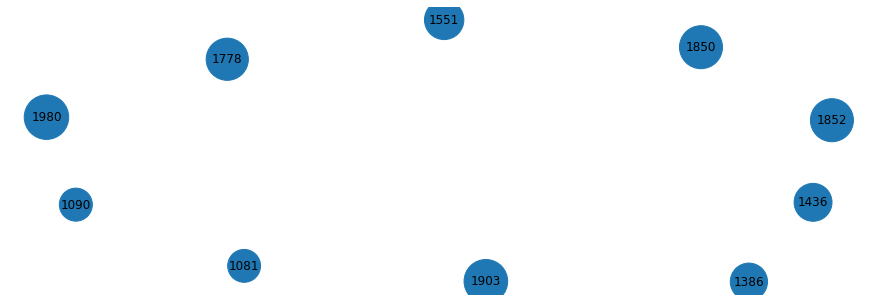

In [ ]:
# Get the agents network at the beginning
G = df.agents_network.iloc[0]

# Get the agents balance
node_balances = nx.get_node_attributes(G,'balance')
node_labels = {node: f"{value :.0f}"
               for node, value
               in node_balances.items()}

# Node sizes
sizes = list(node_balances.values())

# Prepare the figure
plt.figure(figsize=(12, 4))

# Draw the nodes
pos = nx.spring_layout(G)
nx.draw(G,
        pos,
        node_size=sizes)

# Draw the balances
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Show the visualization
plt.show()

In [ ]:
df = simulation_result.copy()
df

,agents_network,population,treasury,simulation,subset,run,substep,timestep
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,0,0
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,1
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,2
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,3
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,1,1,4
...,...,...,...,...,...,...,...,...
997,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,496
998,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,497
999,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,498
1000,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",10,0,0,0,2,1,499


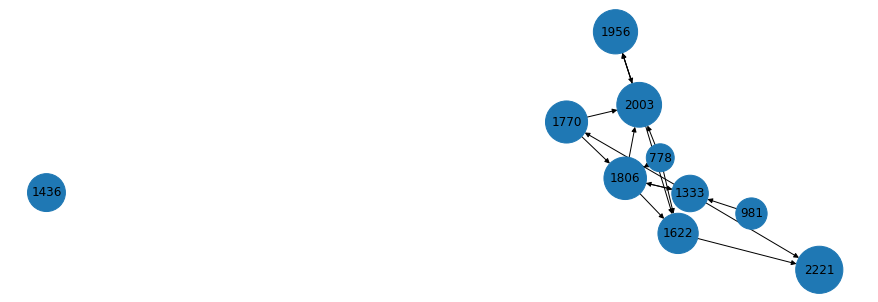

In [ ]:
# Get the agents network after 2 rounds
G = df.agents_network.iloc[2]

# Get the agents balance
node_balances = nx.get_node_attributes(G,'balance')
node_labels = {node: f"{value :.0f}"
               for node, value
               in node_balances.items()}

# Node sizes
sizes = list(node_balances.values())

# Prepare the figure
plt.figure(figsize=(12, 4))

# Draw the nodes
pos = nx.spring_layout(G)
nx.draw(G,
        pos,
        node_size=sizes)

# Draw the balances
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Show the visualization
plt.show()

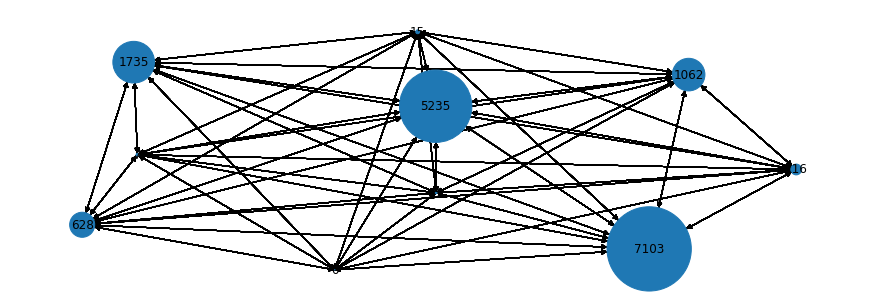

In [ ]:
# Get the agents network at the end
G = df.agents_network.iloc[-1]

# Get the agents balance
node_balances = nx.get_node_attributes(G,'balance')
node_labels = {node: f"{value :.0f}"
               for node, value
               in node_balances.items()}

# Node sizes
sizes = list(node_balances.values())

# Prepare the figure
plt.figure(figsize=(12, 4))

# Draw the nodes
pos = nx.spring_layout(G)
nx.draw(G,
        pos,
        node_size=sizes)

# Draw the balances
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Show the visualization
plt.show()